# Autoregressive Models

In this practical, we'll go over the following topics:
- Autoregressive models and when to use them
- Implementing equivariances in Autoregressive GNNs
- Evaluating scientific AI models

But first, a short introduction on the dataset used for this practical.

![Boids gif](figures/boids.gif)

## Boids (by Craig Reynolds)

The Boids algorithm, developed by Craig Reynolds [2], aims to replicate the behavior of flocking birds.

The simplest setting, used in this practical, follows three simple rules:

1. Separation: Each boid should steer away from crowding local flockmates (avoiding collisions)
2. Alignment: Each boid should steer towards the average heading of local flockmates
3. Cohesion: Each boid should steer towards the average position of local flockmates

With some parameter tuning, these rules allow for some surprisingly realistic behavior. A gif of one of the simulations is shown above.

### Implementation details

Our dataset consists of 1000 samples of Boids simulations. Each simulation has 25 Boids and continues for 1000 timesteps. The Boids fly around in a 2D grid of 1000 x 1000 units.

In our simulations, Boids steer away from eachother (Separation) if they are within 16 units of eachother. Boids steer towards the average heading/position of all (local) flockmates within 40 units.*
Finally, we use periodic boundary conditions; Boids cannot leave the screen, they re-enter on the other side (pacman style).

* We use Euclidean distance (with PBC) here to compute the distance between boids. For a more detailed explanation, visit [The minimum image convention](https://en.wikibooks.org/wiki/Molecular_Simulation/Periodic_Boundary_Conditions) section of the wikibooks page on PBC.

## Problem setting

Boids simulations feature complex interactions between multiple actors (nodes). The simulation can be chaotic and very sensitive to initial conditions.


This makes it an interesting playground for the models/frameworks discussed in the course. In this practical, we will implement an AR model from scratch, then gradually introduce equivariances and training/evaluation methods.


In [2]:
import torch
import torch_geometric
from torch_geometric.data import Data, DataLoader, InMemoryDataset
import torch.nn.functional as F
from torch.nn.utils import clip_grad_norm_
from typing import Tuple
import random
import numpy as np
import matplotlib.pyplot as plt
import os

c:\Python312\Lib\site-packages\torch_geometric\typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
c:\Python312\Lib\site-packages\torch_geometric\typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
c:\Python312\Lib\site-packages\torch_geometric\typing.py:113: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(
c:\Python312\Lib\site-packages\torch_geometric\typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: [WinError 127] The specified p

## Data exploration

First let's look at the data structure, and some statistics.

In [3]:
base = "../../data/boids/raw"
files = [f for f in os.listdir(base) if f.endswith(".npy")]
trajectories = [np.load(os.path.join(base, f)) for f in files]

print(len(trajectories))

26


In [4]:
print("Single trajectory shape:")
print(trajectories[0].shape)
print("The axes and their cardinalities; (Timesteps:1000, Boids:25, (Position X, Position Y, Velocity x, Velocity y):4)")

Single trajectory shape:
(1000, 25, 4)
The axes and their cardinalities; (Timesteps:1000, Boids:25, (Position X, Position Y, Velocity x, Velocity y):4)


In [5]:
# Print the mean, std, min and max of the boid positions, velocities
positions = np.array([t[:, :, :2] for t in trajectories])
velocities = np.array([t[:, :, 2:] for t in trajectories])

print("Position mean, std, min, max:")
# Round to 2 decimal places
print(round(np.mean(positions),2), round(np.std(positions),2), round(np.min(positions), 2), round(np.max(positions), 2))
print()
print("Velocity mean, std, min, max:")
# Round to 2 decimal places
print(round(np.mean(velocities),2), round(np.std(velocities),2), round(np.min(velocities), 2), round(np.max(velocities), 2))

Position mean, std, min, max:
500.32 290.61 0.0 1000.0

Velocity mean, std, min, max:
-0.35 2.96 -6.0 6.0


In [6]:
def plot_state(trajectory, timestep):
    fig, ax = plt.subplots()
    # Plot dots for the boids
    ax.scatter(trajectory[timestep, :, 0], trajectory[timestep, :, 1])
    # plot the boid velocities as arrows
    for i in range(trajectory.shape[1]):
        # NOTE: The arrows are made larger for effect
        ax.arrow(trajectory[timestep, i, 0], trajectory[timestep, i, 1], trajectory[timestep, i, 2]*5, trajectory[timestep, i, 3]*5)
    return ax

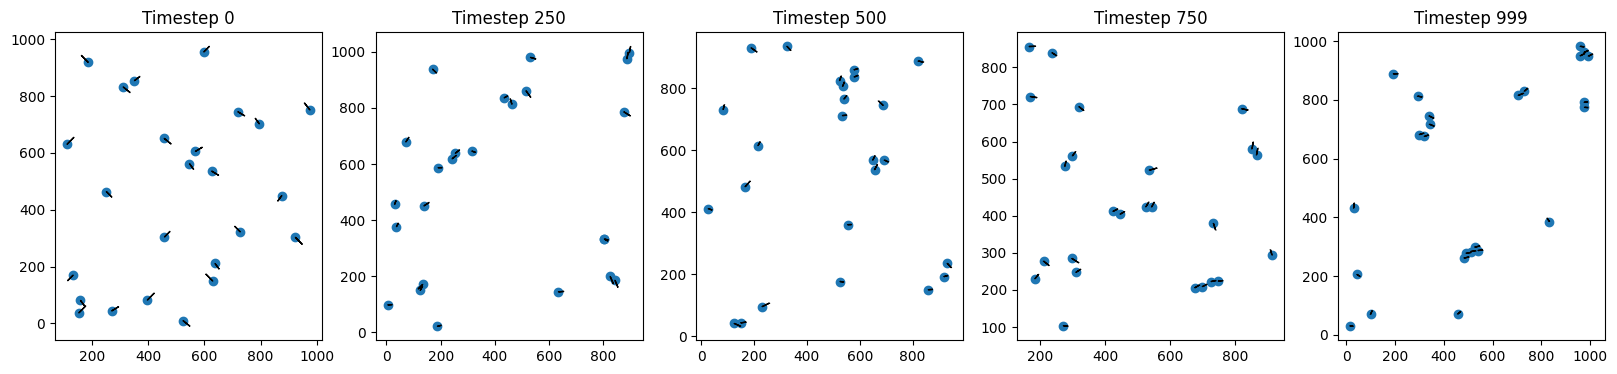

In [7]:
# Plot timesteps 0, 250, 500, 750, 999 for the first trajectory
trajectory = trajectories[0]
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
for i, t in enumerate([0, 250, 500, 750, 999]):
    axs[i].set_title(f"Timestep {t}")
    # Plot dots for the boids
    axs[i].scatter(trajectory[t, :, 0], trajectory[t, :, 1])
    # plot the boid velocities as arrows
    for j in range(trajectory.shape[1]):
        # NOTE: The arrows are made larger for effect
        axs[i].arrow(trajectory[t, j, 0], trajectory[t, j, 1], trajectory[t, j, 2]*5, trajectory[t, j, 3]*5)
plt.show()

In the plot above, you can see that after some warmup time, the boids start to form flocks. Flocking behavior is a form of inter-node communication, which we will come back to again later.

Thinking back to the Geometric Deep Learning framework, we can identify the following symmetries in the data:

- The boids are equivariant to permutations, ie it does not matter in which order we compute the update rules for the boids.
- Local flocks of boids are equivariant to translation, rotation and reflection.

Following these symmetries, it makes sense to model the boids using a Graph Neural Network (GNN). Specifically, since we are dealing with inter-node communication, we will be implementing a Message Passing GNN here.

But first, we create a `torch_geometric` InMemoryDataset object, to model the data as a graph.

In [8]:
class AR_Boids_Dataset(InMemoryDataset):
    def __init__(self, raw_data_path, processed_data_path, root=None, transform=None, pre_transform=None, post_transform=None, solution_idx_range=(0, 25), timesteps=1000, processed_file_name="AR1_Boids.pt"):
        self.raw_data_path = raw_data_path
        self.processed_data_path = processed_data_path
        self.solution_idx_range = solution_idx_range
        self.timesteps = timesteps
        self.processed_file_name = processed_file_name
        self.pre_transform = pre_transform
        self.transform = transform
        self.post_transform = post_transform
        super(AR_Boids_Dataset, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0], weights_only=False)

    @property
    def processed_file_names(self):
        return [self.processed_file_name]

    @property
    def raw_file_names(self):
        return [pfn for pfn in os.listdir(self.raw_data_path) if (self.solution_idx_range[0] <= int(pfn.split("_")[-1][:-4]) < self.solution_idx_range[1])]

    def download(self):
        pass

    def __len__(self):
        return (self.timesteps - 1) * (self.solution_idx_range[1] - self.solution_idx_range[0])

    def process(self):
        data_list = []
        for idx, raw_path in enumerate(self.raw_file_names):
            trajectory = np.load(self.raw_data_path + raw_path)

            if self.transform is not None:
                trajectory = self.transform(trajectory)

            for t in range(trajectory.shape[0] - 1):
                x = torch.tensor(trajectory[t], dtype=torch.float)
                y_temp = torch.tensor(trajectory[t+1], dtype=torch.float)
                # y_temp is (position x, position y, velocity x, velocity y) for the next timestep
                # However, we want delta position and delta velocity
                # Luckily, the delta poisition is just the velocity from the next timestep, and the delta velocity is the acceleration
                # So we can just take the last two elements of y to get the delta velocity
                # First we copy the last two columns of y to the first two columns of y
                y = y_temp.clone()
                y[:, :2] = y_temp[:, 2:]
                # Then we calculate the acceleration
                y[:, 2:] = y_temp[:, 2:] - x[:, 2:]    # (V_x ^ (t+1), V_y ^ (t+1), a_x, a_y)

                # fully connected graph
                edge_index = torch.tensor([[i, j] for i in range(trajectory.shape[1]) for j in range(trajectory.shape[1]) if i != j], dtype=torch.long).t().contiguous()

                if self.post_transform is not None:
                    data = self.post_transform(data)

                data = Data(x=x, y=y, edge_index=edge_index)
                data_list.append(data)
        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_data_path+self.processed_file_name)

    def __getitem__(self, idx):
        return self.get(idx)

    def __repr__(self):
        return f'{self.__class__.__name__}({len(self)})'

In [9]:
train_dataset = AR_Boids_Dataset(
    raw_data_path="../../data/boids/raw/",
    processed_data_path="../../data/boids/processed/",
    root="../../data/boids/",
    solution_idx_range=(0, 15),
    timesteps=1000,
    processed_file_name="AR1_Boids.pt"
)

validation_dataset = AR_Boids_Dataset(
    raw_data_path="../../data/boids/raw/",
    processed_data_path="../../data/boids/processed/",
    root="../../data/boids/",
    solution_idx_range=(16, 25),
    timesteps=1000,
    processed_file_name="AR1_VAL_Boids.pt"
)


print(train_dataset)
print(validation_dataset)


data_0 = train_dataset[0]
print(data_0)
print(data_0.keys)
print("Pos x, Pos y, Vel x, Vel y")
print(data_0.x[0,:])

AR_Boids_Dataset(14985)
AR_Boids_Dataset(8991)
Data(x=[25, 4], edge_index=[2, 600], y=[25, 4])
<bound method BaseData.keys of Data(x=[25, 4], edge_index=[2, 600], y=[25, 4])>
Pos x, Pos y, Vel x, Vel y
tensor([719., 745.,   5.,  -3.])


## Autoregressive Models
In general, when dealing with simulations spanning multiple timesteps, we can define the learning problem as follows.

Let $X^{0:T-1}$ denote the states spanning across timesteps $t=0$ through $t=T-1$. Given the initial state $X^0$, our goal is to accurately predict the future states $X^{1:T-1}$. In the probabilistic case, we want to learn a model with parameters $\theta$ for the probability distribution $P_\theta(X^{1:T-1}|X^0)$.*

In some systems, such as in the Boids setting, the next state X^{t+1} is only dependent on the current state X^t. Such systems are memoryless, and are often said to be _Markovian_. The Markov property allows us to rewrite the learning task to $P_\theta(X^{1:T-1}|X^0) = \prod_{t=0}^{T-2} P_\theta(X^{t+1} | X^t)$

Here, $P_\theta(X^{t+1} | X^t)$ is the _Autoregressive model_ - literally meaning it is used to autoregressively construct the full trajectory of the system. Note that this model is autoregressive in time; not space.

*: In this practical, we will not be building a probabilistic model. So instead of parameterizing a distribution, we learn a function $f_\theta: X^t \rarr X^{t+1}$.

### Autoregressive set model

Below, we create the simplest AR model for the Boids system; a fully connected GNN (essentially a set model).

Given a fully connected graph $X^t$, representing the Boids system at time $t$; it learns to predict the next state of the system $X^{t+1}$.

Note here that we use all features from the dataset as node features. This causes the model to not be equivariant to some group actions, that are relevant in the Boids setting.

---

Tick the equivariance(s) of this model:

- <input
      type="checkbox"
      id="eq0"
      name="perm"
      value="perm" />
    <label for="eq1">Permutational Equivariance</label>

- <input
      type="checkbox"
      id="eq1"
      name="space"
      value="space" />
    <label for="eq1">Space Translation Equivariance</label>

- <input
      type="checkbox"
      id="eq2"
      name="time"
      value="time" />
    <label for="eq2">Time Translation Equivariance</label>

- <input
      type="checkbox"
      id="eq3"
      name="rot"
      value="rot" />
    <label for="eq3">Rotation/Reflection Equivariance</label>

In [10]:
class AR_Set_Model(torch.nn.Module):
    def __init__(self, node_dim=4, emb_dim=16, out_dim=4):
        super(AR_Set_Model, self).__init__()
        self.node_embedding = torch.nn.Linear(node_dim, emb_dim)
        self.conv1 = torch_geometric.nn.GCNConv(emb_dim, emb_dim)
        self.conv2 = torch_geometric.nn.GCNConv(emb_dim, out_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.node_embedding(x)
        x = torch.nn.functional.relu(x)
        x = self.conv1(x, edge_index)
        x = torch.nn.functional.relu(x)
        x = self.conv2(x, edge_index)
        return x

In [11]:
class Trainer:
    def __init__(self, model, train_dataset, validation_dataset, batch_size=1, lr=0.0001, epochs=100, loss_fn=torch.nn.MSELoss(), model_name= "01-AR-Set-Model.pt"):
        """
        Simple Trainer class to train a PyTorch (geometric) model on a dataset.

        Args:
            model: PyTorch model to train
            train_dataset: PyTorch dataset to train on
            validation_dataset: PyTorch dataset to validate on
            batch_size: Batch size for training
            lr: Learning rate
            epochs: Number of epochs to train for
            loss_fn: Loss function to use
        """
        self.model = model
        self.train_dataset = train_dataset
        self.validation_dataset = validation_dataset
        self.batch_size = batch_size
        self.lr = lr
        self.epochs = epochs
        self.loss_fn = loss_fn
        self.model_name = model_name

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print("Using device:", self.device)
        self.model.to(self.device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)

        self.train_loader = self.make_data_loader(self.train_dataset)
        self.validation_loader = self.make_data_loader(self.validation_dataset, shuffle=False)

    def make_data_loader(self, dataset, shuffle=True):
        return DataLoader(dataset, batch_size=self.batch_size, shuffle=shuffle)

    def train_loop(self):
        """
        Train loop for the model
        """
        best_model_loss = np.inf
        for epoch in range(self.epochs):
            # Train the model
            self.model.train()
            mean_train_loss = 0
            for i, data in enumerate(self.train_loader):
                data = self.train_dataset[i].to(self.device)
                self.optimizer.zero_grad()
                out = self.model(data)
                loss = self.loss_fn(out, data.y)
                loss.backward()
                self.optimizer.step()
                mean_train_loss += loss.item()
            mean_train_loss /= i

            # Validate the model
            self.model.eval()
            mean_val_loss = 0
            with torch.no_grad():
                for i, data in enumerate(self.validation_loader):
                    data = self.validation_dataset[i].to(self.device)
                    out = self.model(data)
                    loss = self.loss_fn(out, data.y)
                    mean_val_loss += loss.item()
                mean_val_loss /= i

            if mean_val_loss < best_model_loss:
                best_model_loss = mean_val_loss
                torch.save(self.model.state_dict(), f"../../models/{self.model_name}")

            print(f"Epoch {epoch}, Mean Train Loss: {mean_train_loss}, Mean Validation Loss: {mean_val_loss}")



In [11]:
model = AR_Set_Model(emb_dim=64)
trainer = Trainer(model, train_dataset, validation_dataset, batch_size=8, loss_fn=torch.nn.MSELoss(), epochs=100, model_name="01-AR-Set-Model.pt")
trainer.train_loop()

Using device: cuda


c:\Python312\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 0, Mean Train Loss: 116.65049430926852, Mean Validation Loss: 28.963502348265475
Epoch 1, Mean Train Loss: 3.999818750549241, Mean Validation Loss: 23.93505015802086
Epoch 2, Mean Train Loss: 3.606612415028586, Mean Validation Loss: 23.143549235506136
Epoch 3, Mean Train Loss: 3.5958673077283922, Mean Validation Loss: 22.972979925194704
Epoch 4, Mean Train Loss: 3.8856800639304767, Mean Validation Loss: 26.705327995526186
Epoch 5, Mean Train Loss: 3.641617322566353, Mean Validation Loss: 23.2448399735686
Epoch 6, Mean Train Loss: 3.96966714780724, Mean Validation Loss: 29.44930533819292
Epoch 7, Mean Train Loss: 4.341298597513261, Mean Validation Loss: 28.406608962205937
Epoch 8, Mean Train Loss: 4.264698102012141, Mean Validation Loss: 26.440589967415146
Epoch 9, Mean Train Loss: 4.048862428761903, Mean Validation Loss: 25.958907586808515
Epoch 10, Mean Train Loss: 4.140312838478007, Mean Validation Loss: 28.819224270135297
Epoch 11, Mean Train Loss: 4.337253311962224, Mean Vali

### Q1: Implementing rollout code

We have a working model now to predict $\hat{X}^{t+1}$ given $X^t$. However, we of course want to be able to generate trajectories longer than one step (ie for i steps: $\hat{X}^{t+1:t+i}$), given $X^t$.

We sometimes call this a `rollout` - essentially a multi-step prediction.

Q1: Complete the method below, which generates a rollout of `timesteps` steps, for a given model `model`, and dataset `dataset` *.

HINT: What should happen if the position $x_i, y_i$ of boid $i$ are predicted to move $dx_i, dy_i$, such that $x_i + dx_i > \text{width}$ or $y_i + dy_i > \text{height}$?

*: If you check the cell below the next cell, we already made a dataset for you that only contains initial positions :)

In [20]:
def compute_ar_set_model_rollouts(model, dataset, timesteps=1000, device='cuda', mode="residual", width = 1000, height = 1000):
    """
    Predict the rollouts of the model on the dataset starting from the idx

    Args:
        model: PyTorch model
        dataset: PyTorch dataset
        timesteps: Number of timesteps to predict
        device: Device to run the model on
        mode: "residual" or "direct"
        - In the solution above, we used the "residual" mode, where the model predicts the change in position and change in velocity
        - In the "direct" mode, the model predicts the position and velocity directly (if you do not intend to use this mode, you can ignore this argument)
        width: Width of the PBC box
        height: Height of the PBC box
    Returns:
        rollouts: Rollouts of the model on the dataset
        - Should be a torch tensor of shape (Batch, Timesteps, Boids, Node_dim)
    """
    rollouts = torch.empty((len(dataset), timesteps, dataset[0].x.shape[0], dataset[0].x.shape[1]), device=device)
    print(rollouts.shape)

    # new code below
    model.eval()
    dtype = dataset[0].x.dtype

    with torch.no_grad():
        for b in range(len(dataset)):
            data = dataset[b]
            # current state (N, F) and graph
            x_t = data.x.to(device=device, dtype=dtype)           # [x, y, vx, vy]
            edge_index = data.edge_index.to(device)

            for t in range(timesteps):
                # one-step prediction
                if mode == "residual":
                    delta = model(Data(x=x_t, edge_index=edge_index))   # predicts Δ[x, y, vx, vy]
                    x_next = x_t + delta
                else:  # "direct"
                    x_next = model(Data(x=x_t, edge_index=edge_index))  # predicts next [x, y, vx, vy]

                # Periodic Boundary Conditions (wrap positions only)
                x_next[:, 0] = (x_next[:, 0] + width) % width    # x
                x_next[:, 1] = (x_next[:, 1] + height) % height  # y

                # store & advance
                rollouts[b, t] = x_next
                x_t = x_next.detach()


    return rollouts

In [21]:
def keep_01(data):
    return data[0:2, :, :]

initial_states_validation_dataset = AR_Boids_Dataset(
    raw_data_path="../../data/boids/raw/",
    processed_data_path="../../data/boids/processed/",
    root="../../data/boids/",
    solution_idx_range=(16, 25),
    timesteps=2,
    processed_file_name="AR1_VAL_init.pt",
    transform=keep_01
    )

ar_set_model = AR_Set_Model(emb_dim=64)
ar_set_model.load_state_dict(torch.load("../../models/01-AR-Set-Model.pt"))
device = 'cuda' if torch.cuda.is_available() else 'cpu'
ar_set_model.to(device)
ar_set_model.eval()

ar_set_model_rollout = compute_ar_set_model_rollouts(ar_set_model, initial_states_validation_dataset, timesteps=1000, device=device)

C:\Users\liamm\AppData\Local\Temp\ipykernel_14484\412190819.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ar_set_model.load_state_dict(torch.load("../../models/01-AR-

torch.Size([9, 1000, 25, 4])


We'll evaluate these rollouts later.

### Quick recap on equivariances

<img src="figures/boids-translational-equivariance.png" alt="drawing" width="250" style="background-color: white; padding: 50px;"/>
<img src="figures/boids-rotational-equivariance.png" alt="drawing" width="250" style="background-color: white; padding: 50px;"/>

The figures above show the equivariances of the Boids system. The system is equivariant to all E(n) transformations; translation,
rotation and reflection.*

Formally, we say a function $f: X \rarr Y$ is _equivariant_ to a group action or transformation $T: X \rarr X$ if there is an equivalent transformation $S: Y \rarr Y$ on the output space of the function such that

$f(T(x)) = S(f(x))$ for each $x \in X$

We won't go into the formal definitions of each equivariance, but if you're interested you can check out the [E(n) Equivariant Graph Neural Networks](https://arxiv.org/pdf/2102.09844) paper [3], the equivariant model is based on.

*: Excluding time translation equivariance, which states that there is no dependence on the time of the system, only the state.

*: Also excluding permutational equivariance; the order of the nodes does not matter.

## Towards Equivariant AR-GNNs
The above model is **not** equivariant to translations in space! This is because we use absolute coordinates as _node features_, which creates a dependence on the absolute coordinate system. Instead, if we do not use the absolute positions as node features - and include the PBC distance as _edge features_ - the predictions will be space translation equivariant.

Let's implement this!

Before, we were not using the fact that boids only affect eachother within a certain radius, since we used a fully connected graph without edge weights.

Before blindly jumping into the new dataset code, let's investigate this behavior.

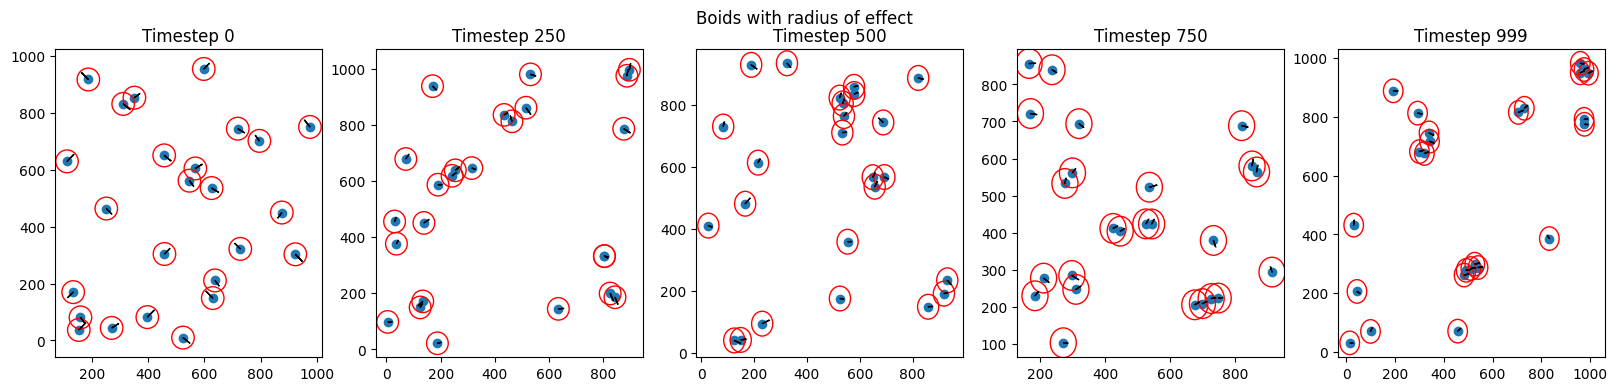

In [12]:
# Plot timesteps 0, 250, 500, 750, 999 for the first trajectory
trajectory = trajectories[0]
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
fig.suptitle("Boids with radius of effect")
radius = 40

for i, t in enumerate([0, 250, 500, 750, 999]):
    axs[i].set_title(f"Timestep {t}")
    # Plot dots for the boids
    axs[i].scatter(trajectory[t, :, 0], trajectory[t, :, 1])
    # Draw a red circle around each boid to indicate the radius
    for j in range(trajectory.shape[1]):
        circle = plt.Circle((trajectory[t, j, 0], trajectory[t, j, 1]), radius, color='r', fill=False)
        axs[i].add_artist(circle)
    # plot the boid velocities as arrows
    for j in range(trajectory.shape[1]):
        # NOTE: The arrows are made larger for effect
        axs[i].arrow(trajectory[t, j, 0], trajectory[t, j, 1], trajectory[t, j, 2]*5, trajectory[t, j, 3]*5)
plt.show()

Above, we show the boids with their radius of effect. As expected, boids who are farther than `radius=40` units away from eachother, are shown to not affect eachother.

## Q2: Implement your own model

As discussed above, the Boids system is equivariant to
- Permutation
- Translation
- Rotation/Reflection

Your next task is to build a model that is equivariant to permutation and translation. Make sure your model adheres to the PBC, either via the loss function or position updates.

For this you will have to code up:

1. The `InMemoryDataset` used when training your model.
2. The Permutation/Translation Equivariant model `TranslationalEquivariantModel`
3. Possibly a new rollout method `model2_rollouts`
    - HINT: Depending on your design choices, you may need to store the initial coordinates of your nodes.


In [13]:
from tqdm import trange

class Equivariant_Boids_Dataset(InMemoryDataset):
    def __init__(self, raw_data_path, processed_data_path, root=None, transform=None, pre_transform=None, post_transform=None, solution_idx_range=(0, 25), timesteps=1000, processed_file_name="AR1_Boids.pt", L = 1000):
        self.raw_data_path = raw_data_path
        self.processed_data_path = processed_data_path
        self.solution_idx_range = solution_idx_range
        self.timesteps = timesteps
        self.processed_file_name = processed_file_name
        self.pre_transform = pre_transform
        self.transform = transform
        self.post_transform = post_transform
        self.L = L
        super(Equivariant_Boids_Dataset, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0], weights_only=False)

    @property
    def processed_file_names(self):
        return [self.processed_file_name]

    @property
    def raw_file_names(self):
        return [pfn for pfn in os.listdir(self.raw_data_path) if (self.solution_idx_range[0] <= int(pfn.split("_")[-1][:-4]) < self.solution_idx_range[1])]

    def download(self):
        pass

    def __len__(self):
        return (self.timesteps - 1) * (self.solution_idx_range[1] - self.solution_idx_range[0])

    def process(self):
        # TODO: TODO: TODO: TODO: TODO:
        """
        Your code goes here.

        Process the raw data and save the processed data to disk, see the AR_Boids_Dataset for an example.

        HINT: Make sure your learning task adheres to the PBC constraints - depending on your approach,
        you may need to include the PBC constraints in the data processing step.
        """
        data_list = []

        # gather raw files in selected range and sort by numeric id
        raw_files = self.raw_file_names
        raw_files = sorted(raw_files, key=lambda p: int(p.split("_")[-1][:-4]))

        init_positions_list = []

        for pfn in raw_files:
            traj = np.load(os.path.join(self.raw_data_path, pfn))  # (T, N, 4) with [x,y,vx,vy]
            T, N, F = traj.shape
            T = min(T, self.timesteps)

            # store initial positions for this trajectory (for equivariant rollouts)
            pos0 = torch.from_numpy(traj[0, :, :2]).float()  # (N,2)
            init_positions_list.append(pos0)

            # prebuild complete directed graph (no self-loops)
            recv, send = [], []
            for i in range(N):
                for j in range(N):
                    if i != j:
                        recv.append(i); send.append(j)
            edge_index = torch.tensor([recv, send], dtype=torch.long)

            # build AR pairs (t -> t+1)
            pos = traj[:T, :, :2]  # (T,N,2)
            vel = traj[:T, :, 2:]  # (T,N,2)

            for t in range(T - 1):
                x_t = np.concatenate([pos[t], vel[t]], axis=-1)  # (N,4)

                # residual targets with PBC (minimum image convention)
                dpos = pos[t + 1] - pos[t]                        # (N,2)
                dpos = (dpos + self.L / 2.0) % self.L - self.L / 2.0
                dvel = vel[t + 1] - vel[t]                        # (N,2)

                y_res = np.concatenate([dpos, dvel], axis=-1)     # (N,4)

                data_list.append(
                    Data(
                        x=torch.from_numpy(x_t).float(),
                        y=torch.from_numpy(y_res).float(),
                        edge_index=edge_index.clone(),
                        pos0=pos0.clone(),  # keep initial positions if needed by rollout
                    )
                )

        # collate & save dataset
        data, slices = self.collate(data_list)
        os.makedirs(self.processed_data_path, exist_ok=True)
        torch.save((data, slices), self.processed_paths[0])

        # also save stack of initial positions expected by the notebook
        init_positions = torch.stack(init_positions_list, dim=0)  # (num_traj, N, 2)
        positions_fname = f"positions_{self.processed_file_name[:-3]}.pt"
        torch.save(init_positions, os.path.join(self.processed_data_path, positions_fname))

    def __getitem__(self, idx):
        return self.get(idx)

    def __repr__(self):
        return f'{self.__class__.__name__}({len(self)})'

In [14]:
equivariant_train_dataset = Equivariant_Boids_Dataset(
    raw_data_path="../../data/boids/raw/",
    processed_data_path="../../data/boids/processed/",
    root="../../data/boids/",
    solution_idx_range=(0, 15),
    timesteps=1000,
    processed_file_name="AR1_Boids_Equivariant.pt"
    )

equivariant_validation_dataset = Equivariant_Boids_Dataset(
    raw_data_path="../../data/boids/raw/",
    processed_data_path="../../data/boids/processed/",
    root="../../data/boids/",
    solution_idx_range=(16, 25),
    timesteps=1000,
    processed_file_name="AR1_VAL_Boids_Equivariant.pt"
    )


In [15]:
init_positions = torch.load("../../data/boids/processed/positions_AR1_Boids_Equivariant.pt")
print(init_positions.shape)
init_val_positions = torch.load("../../data/boids/processed/positions_AR1_VAL_Boids_Equivariant.pt")
print(init_val_positions.shape)

torch.Size([15, 25, 2])
torch.Size([9, 25, 2])


C:\Users\liamm\AppData\Local\Temp\ipykernel_14484\3519763002.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  init_positions = torch.load("../../data/boids/processed/posi

In [ ]:
class TranslationalEquivariantModel(torch.nn.Module):
    def __init__(self):
        super(TranslationalEquivariantModel, self).__init__()
        # TODO: TODO: TODO: TODO: TODO:
        self.L = 1000.0  # box size for PBC (wrap relative vectors via minimum-image)
        hidden = 128
        nn = torch.nn

        # Edge MLP: [v_i(2), v_j(2), ||r_ij||^2(1)] -> H
        self.phi_e = nn.Sequential(
            nn.Linear(2 + 2 + 1, hidden), nn.SiLU(),
            nn.Linear(hidden, hidden),   nn.SiLU(),
        )

        # Node MLP: [v_i(2), agg_msg(H)] -> Δv(2)
        self.phi_h = nn.Sequential(
            nn.Linear(2 + hidden, hidden), nn.SiLU(),
            nn.Linear(hidden, 2),
        )


    def forward(self, data):
        # TODO: TODO: TODO: TODO: TODO:
        
        """
        Your code goes here
        """
        
        # NOTE: You may use different data attributes instead of x, edge_index, edge_attr
        # But you should pass a Data object to the model
        # (see the AR_Set_Model for an example and the Trainer class for how this is used)

        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr

        pos, vel = x[:, :2], x[:, 2:]               
        N = pos.size(0)      
        i = edge_index[0]
        j = edge_index[1]

        # minimum-image relative vector 

        rij = pos[i] - pos[j]
        L = torch.tensor(self.L, device=pos.device, dtype=pos.dtype)
        rij = (rij + L / 2) % L - L / 2
        dij2 = (rij * rij).sum(-1, keepdim=True)    

        # edge messages 
        m_ij = self.phi_e(torch.cat([vel[i], vel[j], dij2], dim=-1))  

        # symmetric aggregation (mean) -> permutation equivariant
        m_i = torch.zeros(N, m_ij.size(-1), device=x.device, dtype=x.dtype)
        m_i.index_add_(0, i, m_ij)                  # sum into receiver i
        deg = torch.bincount(i, minlength=N).clamp_min(1).to(x.device)
        m_i = m_i / deg.view(N, 1)

        # velocity update and integrate to get Δx (Δt=1)
        dv = self.phi_h(torch.cat([vel, m_i], dim=-1))   
        v_next = vel + dv
        dx = v_next                                      

        y = torch.cat([dx, dv], dim=-1)                  
        return y

In [32]:
translational_equivariant_model = TranslationalEquivariantModel()
trainer = Trainer(translational_equivariant_model, equivariant_train_dataset, equivariant_validation_dataset, batch_size=8, loss_fn=torch.nn.MSELoss(), epochs=100, model_name="02-Translational-Equivariant-Model.pt")
trainer.train_loop()

Using device: cuda
Epoch 0, Mean Train Loss: 10424.436787567462, Mean Validation Loss: 0.014236949652081766
Epoch 1, Mean Train Loss: 7.726957827430936, Mean Validation Loss: 330.0375371238321
Epoch 2, Mean Train Loss: 59.08364051277476, Mean Validation Loss: 7.041840577911078
Epoch 3, Mean Train Loss: 103.59289891357102, Mean Validation Loss: 724.794149234055
Epoch 4, Mean Train Loss: 91.07769559357814, Mean Validation Loss: 0.226452411256087
Epoch 5, Mean Train Loss: 110.34524526505894, Mean Validation Loss: 4191.523440761006
Epoch 6, Mean Train Loss: 85.4128036220969, Mean Validation Loss: 54.32888932538054
Epoch 7, Mean Train Loss: 116.43239782244416, Mean Validation Loss: 0.012441345923003853
Epoch 8, Mean Train Loss: 58.19735709681084, Mean Validation Loss: 99.84855134850194
Epoch 9, Mean Train Loss: 89.08308764973579, Mean Validation Loss: 0.010728786767918396
Epoch 10, Mean Train Loss: 46.57921238409185, Mean Validation Loss: 4345.946339499388
Epoch 11, Mean Train Loss: 77.2639

In [17]:
def model2_rollouts(model, dataset, positions_dataset, timesteps=1000, device='cuda', mode="residual", width = 1000, height = 1000):
    """
    Predict the rollouts of the model on the dataset starting from the idx

    Args:
        model: PyTorch model
        dataset: PyTorch dataset
        timesteps: Number of timesteps to predict
        device: Device to run the model on
        mode: "residual" or "direct"
        - In the solution above, we used the "residual" mode, where the model predicts the change in position and velocity
        - In the "direct" mode, the model predicts the position and velocity directly (if you do not intend to use this mode, you can ignore this argument)
        width: Width of the PBC box
        height: Height of the PBC box
    Returns:
        rollouts: Rollouts of the model on the dataset
        - Should be a torch tensor of shape (Batch, Timesteps, Boids, Node_dim)
    """
    rollouts = torch.empty((len(dataset), timesteps, dataset[0].x.shape[0], dataset[0].x.shape[1]), device=device)
    print(rollouts.shape)

    # code inserted below
    model = model.to(device).eval()
    init_pos = positions_dataset.to(device)
    B, N, _ = init_pos.shape
    Lx, Ly = float(width), float(height)
    Traw = getattr(dataset, "timesteps", timesteps)

    # use the first sample to infer feature size & edge_index template
    d0 = dataset[0]
    F = d0.x.shape[1]
    # Prefer dataset-provided edge_index (keeps exact ordering); fallback to dense complete graph
    if hasattr(d0, "edge_index") and d0.edge_index is not None:
        edge_index_template = d0.edge_index.to(device)
    else:
        recv, send = [], []
        for i in range(N):
            for j in range(N):
                if i != j:
                    recv.append(i); send.append(j)
        edge_index_template = torch.tensor([recv, send], dtype=torch.long, device=device)

    rollouts = torch.empty((B, timesteps, N, F), device=device, dtype=d0.x.dtype)

    with torch.no_grad():
        for b in range(B):
            # index of the first sample (t=0) for trajectory b
            start_idx = b * (Traw - 1)
            db0 = dataset[start_idx]

            # initial absolute state: positions from positions_dataset, velocities from dataset sample
            pos = init_pos[b].clone()                 # [N,2]
            vel = db0.x[:, 2:4].to(device).clone()    # [N,2]

            # fixed edge_index for this trajectory
            edge_index = getattr(db0, "edge_index", edge_index_template).to(device)

            # t = 0 frame
            rollouts[b, 0] = torch.cat([pos, vel], dim=-1)

            for t in range(1, timesteps):
                x_in = torch.cat([pos, vel], dim=-1)          # [N,4]
                data_in = Data(x=x_in, edge_index=edge_index) # pass a Data object as required
                y_hat = model(data_in)                        # [N,4]

                if mode == "residual":
                    dpos = y_hat[:, :2]
                    dvel = y_hat[:, 2:]
                    vel = vel + dvel
                    pos = pos + dpos
                elif mode == "direct":
                    pos = y_hat[:, :2]
                    vel = y_hat[:, 2:]
                else:
                    raise ValueError("mode must be 'residual' or 'direct'")

                # Periodic Boundary Conditions on positions
                pos[:, 0] = torch.remainder(pos[:, 0], Lx)
                pos[:, 1] = torch.remainder(pos[:, 1], Ly)

                rollouts[b, t] = torch.cat([pos, vel], dim=-1)

    return rollouts

In [22]:
initial_states_validation_dataset = AR_Boids_Dataset(
    raw_data_path="../../data/boids/raw/",
    processed_data_path="../../data/boids/processed/",
    root="../../data/boids/",
    solution_idx_range=(16, 25),
    timesteps=2,
    processed_file_name="AR1_VAL_Equivariant_init.pt",
    transform=keep_01
    )

print(initial_states_validation_dataset[1])

translational_equivariant_model = TranslationalEquivariantModel()
translational_equivariant_model.load_state_dict(torch.load("../../models/02-Translational-Equivariant-Model.pt"))
translational_equivariant_model_rollout = model2_rollouts(translational_equivariant_model, initial_states_validation_dataset, init_val_positions.to(device), timesteps=1000, device=device)

Data(x=[25, 4], edge_index=[2, 600], y=[25, 4])
torch.Size([9, 1000, 25, 4])


C:\Users\liamm\AppData\Local\Temp\ipykernel_14484\2797361435.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  translational_equivariant_model.load_state_dict(torch.load(

Above, we show the boids with their radius of effect. As expected, boids who are farther than `radius=40` units away from eachother, are shown to not affect eachother.

So in our dataset, we form undirected edges between nodes with a max PBC distance of 40 units.

## Q3 E(n) Equivariant Graph Neural Networks

In Satorras, Hoogeboom, Welling's paper [3] with the same name, they introduce a relatively simple model that is equivariant to E(n) transformations.
You can check the official [implementation](https://github.com/vgsatorras/egnn).

In [24]:
class EGNN_Dataset(InMemoryDataset):
    def __init__(self, raw_data_path, processed_data_path, root=None,
                 transform=None, pre_transform=None, post_transform=None,
                 solution_idx_range=(0, 25), timesteps=1000,
                 processed_file_name="AR1_Boids.pt", L=1000):
        self.raw_data_path = raw_data_path
        self.processed_data_path = processed_data_path
        self.solution_idx_range = solution_idx_range
        self.timesteps = timesteps
        self.processed_file_name = processed_file_name
        self.pre_transform = pre_transform
        self.transform = transform
        self.post_transform = post_transform
        self.L = L
        super(EGNN_Dataset, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0], weights_only=False)

    @property
    def processed_file_names(self):
        return [self.processed_file_name]

    @property
    def raw_file_names(self):
        return [pfn for pfn in os.listdir(self.raw_data_path)
                if (self.solution_idx_range[0] <= int(pfn.split("_")[-1][:-4]) < self.solution_idx_range[1])]

    def download(self):
        pass

    def __len__(self):
        return (self.timesteps - 1) * (self.solution_idx_range[1] - self.solution_idx_range[0])

    def process(self):
        data_list = []
        pos_all = []
        vel_all = []
        raw_files = sorted(self.raw_file_names, key=lambda p: int(p.split("_")[-1][:-4]))

        # Collect all positions and velocities for normalization
        for pfn in raw_files:
            traj = np.load(os.path.join(self.raw_data_path, pfn))  # (T, N, 4)
            pos_all.append(traj[:, :, :2])
            vel_all.append(traj[:, :, 2:])
        # Concatenate along time axis and then reshape
        pos_all = np.concatenate(pos_all, axis=0)  # (total_timesteps, N, 2)
        pos_all = pos_all.reshape(-1, pos_all.shape[-1])  # flatten to (samples, features)
        vel_all = np.concatenate(vel_all, axis=0)
        vel_all = vel_all.reshape(-1, vel_all.shape[-1])

        # Calculate mean and std for normalization
        pos_mean, pos_std = pos_all.mean(axis=0), pos_all.std(axis=0) + 1e-8
        vel_mean, vel_std = vel_all.mean(axis=0), vel_all.std(axis=0) + 1e-8

        for pfn in raw_files:
            traj = np.load(os.path.join(self.raw_data_path, pfn))
            T, N, F = traj.shape
            T = min(T, self.timesteps)
            # Save initial positions
            pos0 = torch.from_numpy(traj[0, :, :2]).float()
            # Build complete directed graph (no self loops)
            recv, send = [], []
            for i in range(N):
                for j in range(N):
                    if i != j:
                        recv.append(i)
                        send.append(j)
            edge_index = torch.tensor([recv, send], dtype=torch.long)

            for t in range(T - 1):
                # Normalize input
                pos_t = (traj[t, :, :2] - pos_mean) / pos_std
                vel_t = (traj[t, :, 2:] - vel_mean) / vel_std
                x_t = np.concatenate([pos_t, vel_t], axis=-1)

                # Compute normalized residual targets with PBC for positions
                dpos = traj[t + 1, :, :2] - traj[t, :, :2]
                dpos = (dpos + self.L / 2.0) % self.L - self.L / 2.0
                dpos = (dpos - pos_mean) / pos_std

                dvel = traj[t + 1, :, 2:] - traj[t, :, 2:]
                dvel = (dvel - vel_mean) / vel_std

                y_res = np.concatenate([dpos, dvel], axis=-1)

                data_list.append(
                    Data(
                        x=torch.from_numpy(x_t).float(),
                        y=torch.from_numpy(y_res).float(),
                        edge_index=edge_index.clone(),
                        pos0=pos0.clone(),
                    )
                )

        data, slices = self.collate(data_list)
        os.makedirs(self.processed_data_path, exist_ok=True)
        torch.save((data, slices), self.processed_paths[0])

    def __getitem__(self, idx):
        return self.get(idx)

    def __repr__(self):
        return f'{self.__class__.__name__}({len(self)})'


In [25]:
egnn_train_dataset = EGNN_Dataset(
    raw_data_path="../../data/boids/raw/",
    processed_data_path="../../data/boids/processed/",
    root="../../data/boids/",
    solution_idx_range=(0, 15),
    timesteps=1000,
    processed_file_name="EGNN_Boids_Equivariant.pt"
    )

egnn_validation_dataset = EGNN_Dataset(
    raw_data_path="../../data/boids/raw/",
    processed_data_path="../../data/boids/processed/",
    root="../../data/boids/",
    solution_idx_range=(16, 25),
    timesteps=1000,
    processed_file_name="EGNN_VAL_Boids_Equivariant.pt"
    )


In [ ]:
init_positions = torch.load("../../data/boids/processed/positions_AR1_Boids_Equivariant.pt")
print(init_positions.shape)
init_val_positions = torch.load("../../data/boids/processed/positions_AR1_VAL_Boids_Equivariant.pt")
print(init_val_positions.shape)

In [26]:
# Utilities for aggregation
def unsorted_segment_sum(data, segment_ids, num_segments):
    result = data.new_zeros((num_segments, data.size(1)))
    segment_ids = segment_ids.unsqueeze(-1).expand(-1, data.size(1))
    result.scatter_add_(0, segment_ids, data)
    return result

def unsorted_segment_mean(data, segment_ids, num_segments):
    result = data.new_zeros((num_segments, data.size(1)))
    count = data.new_zeros((num_segments, data.size(1)))
    segment_ids = segment_ids.unsqueeze(-1).expand(-1, data.size(1))
    result.scatter_add_(0, segment_ids, data)
    count.scatter_add_(0, segment_ids, torch.ones_like(data))
    return result / count.clamp(min=1)

# One EGNN layer
class E_GCL(torch.nn.Module):
    def __init__(self, input_nf, output_nf, hidden_nf,
                 edges_in_d=0, act_fn=torch.nn.SiLU(),
                 residual=True, attention=False,
                 normalize=False, coords_agg='mean', tanh=False, L=None):
        super().__init__()
        input_edge = input_nf * 2
        edge_coords_nf = 1
        self.residual = residual
        self.attention = attention
        self.normalize = normalize
        self.coords_agg = coords_agg
        self.tanh = tanh
        self.epsilon = 1e-8
        self.L = L

        self.edge_mlp = torch.nn.Sequential(
            torch.nn.Linear(input_edge + edge_coords_nf + edges_in_d, hidden_nf),
            act_fn,
            torch.nn.Linear(hidden_nf, hidden_nf),
            act_fn
        )
        self.node_mlp = torch.nn.Sequential(
            torch.nn.Linear(hidden_nf + input_nf, hidden_nf),
            act_fn,
            torch.nn.Linear(hidden_nf, output_nf)
        )
        layer = torch.nn.Linear(hidden_nf, 1, bias=False)
        torch.nn.init.xavier_uniform_(layer.weight, gain=0.001)
        coord_mlp = [torch.nn.Linear(hidden_nf, hidden_nf), act_fn, layer]
        if tanh:
            coord_mlp.append(torch.nn.Tanh())
        self.coord_mlp = torch.nn.Sequential(*coord_mlp)

        if attention:
            self.att_mlp = torch.nn.Sequential(
                torch.nn.Linear(hidden_nf, 1),
                torch.nn.Sigmoid()
            )

    def coord2radial(self, edge_index, coord):
        row, col = edge_index
        coord_diff = coord[row] - coord[col]
        if self.L is not None:
            if isinstance(self.L, (list, tuple, torch.Tensor)):
                Lvec = torch.tensor(self.L, device=coord.device, dtype=coord.dtype)
            else:
                Lvec = torch.tensor([self.L]*coord.size(1), device=coord.device, dtype=coord.dtype)
            coord_diff = (coord_diff + 0.5 * Lvec) % Lvec - 0.5 * Lvec
        radial = torch.sum(coord_diff**2, 1).unsqueeze(1)
        if self.normalize:
            norm = torch.sqrt(radial).detach() + self.epsilon
            coord_diff = coord_diff / norm
        return radial, coord_diff

    def edge_model(self, source, target, radial, edge_attr):
        if edge_attr is None:
            out = torch.cat([source, target, radial], dim=1)
        else:
            out = torch.cat([source, target, radial, edge_attr], dim=1)
        out = self.edge_mlp(out)
        if self.attention:
            out = out * self.att_mlp(out)
        return out

    def node_model(self, h, edge_index, edge_attr):
        row, col = edge_index
        agg = unsorted_segment_sum(edge_attr, row, num_segments=h.size(0))
        out = self.node_mlp(torch.cat([h, agg], dim=1))
        if self.residual:
            out = h + out
        return out

    def coord_model(self, coord, edge_index, coord_diff, edge_feat):
        row, col = edge_index
        trans = coord_diff * self.coord_mlp(edge_feat)
        if self.coords_agg == 'sum':
            agg = unsorted_segment_sum(trans, row, num_segments=coord.size(0))
        else:
            agg = unsorted_segment_mean(trans, row, num_segments=coord.size(0))
        coord = coord + agg
        return coord

    def forward(self, h, edge_index, coord, edge_attr=None):
        radial, coord_diff = self.coord2radial(edge_index, coord)
        edge_feat = self.edge_model(h[edge_index[0]], h[edge_index[1]], radial, edge_attr)
        coord = self.coord_model(coord, edge_index, coord_diff, edge_feat)
        h = self.node_model(h, edge_index, edge_feat)
        return h, coord

# Full EGNN model
class EGNN_Boids(torch.nn.Module):
    def __init__(self, in_node_nf, hidden_nf, out_node_nf,
                 in_edge_nf=0, n_layers=4, device="cpu", L=1000.0):
        super().__init__()
        self.hidden_nf = hidden_nf
        self.embedding_in = torch.nn.Linear(in_node_nf - 2, hidden_nf)
        self.embedding_out = torch.nn.Linear(hidden_nf, out_node_nf)
        self.layers = torch.nn.ModuleList([
            E_GCL(hidden_nf, hidden_nf, hidden_nf,
                  edges_in_d=in_edge_nf, act_fn=torch.nn.SiLU(), L=L)
            for _ in range(n_layers)
        ])
        self.device = device
        self.to(device)

    def forward(self, data: torch_geometric.data.Data):
        coord, feats = data.x[:, :2], data.x[:, 2:]
        edges = data.edge_index
        edge_attr = getattr(data, "edge_attr", None)

        h = self.embedding_in(feats)
        for gcl in self.layers:
            h, coord = gcl(h, edges, coord, edge_attr)

        dvel = self.embedding_out(h)

        # Residual Δx is the updated coord minus original coord
        dpos = coord - data.x[:, :2]

        # Concatenate into output [Δx, Δv]
        out = torch.cat([dpos, dvel], dim=-1)
        return out


In [ ]:
# Initialize the EGNN model
egnn_model = EGNN_Boids(
    in_node_nf=4,
    hidden_nf=64,
    out_node_nf=2,    # Δv prediction
    n_layers=4,
    device="cuda" if torch.cuda.is_available() else "cpu"
)

# Trainer for model
egnn_trainer = Trainer(
    egnn_model,
    egnn_train_dataset,
    egnn_validation_dataset,
    batch_size=16,
    loss_fn=torch.nn.MSELoss(),
    epochs=100,
    model_name="03-EGNN-Boids.pt"
)


egnn_trainer.train_loop()


Using device: cuda
Epoch 0, Mean Train Loss: 1.2092895315737169, Mean Validation Loss: 4.430946970580946
Epoch 1, Mean Train Loss: 0.8443866551736307, Mean Validation Loss: 4.642175772185844
Epoch 2, Mean Train Loss: 1.1286809729396279, Mean Validation Loss: 2.3526516572676877
Epoch 3, Mean Train Loss: 0.7391201777855814, Mean Validation Loss: 1.979302469103094
Epoch 4, Mean Train Loss: 0.5611518091705238, Mean Validation Loss: 10.000943343694622
Epoch 5, Mean Train Loss: 0.583112780432591, Mean Validation Loss: 3.975996123384452
Epoch 6, Mean Train Loss: 0.7484177968456832, Mean Validation Loss: 3.32743976949158
Epoch 7, Mean Train Loss: 0.6134107025264579, Mean Validation Loss: 3.6528280366763286
Epoch 8, Mean Train Loss: 0.46578743221520835, Mean Validation Loss: 2.3809497814339964
Epoch 9, Mean Train Loss: 0.467768979137445, Mean Validation Loss: 6.617666651220882
Epoch 10, Mean Train Loss: 0.5946110088883653, Mean Validation Loss: 2.085411388234446
Epoch 11, Mean Train Loss: 0.634

## Q4 Push-forward training

In [ ]:
def pbc_displacement(pos_i: torch.Tensor, pos_j: torch.Tensor, box: torch.Tensor) -> torch.Tensor:
    """
    pos_i, pos_j: (..., 2) or (N,2) tensors
    box: (2,) tensor [Lx, Ly]
    returns: displacement pos_i - pos_j under minimum-image (same shape)
    """
    diff = pos_i - pos_j
    box = box.to(diff.device).to(diff.dtype)
    return (diff + box / 2.0) % box - box / 2.0

def build_radius_graph_pbc(pos: torch.Tensor, radius: float, box: torch.Tensor, self_loops: bool=False) -> torch.Tensor:
    """
    Build edge_index (2, E) for a single graph under PBC.
    pos: (N,2)
    box: (2,) tensor
    radius: float scalar
    Returns: edge_index (2, E) torch.long
    """
    N = pos.shape[0]
    # compute pairwise displacements
    pos_i = pos.unsqueeze(1).expand(N, N, 2)   # (N,N,2)
    pos_j = pos.unsqueeze(0).expand(N, N, 2)
    disp = pbc_displacement(pos_i, pos_j, box) # (N,N,2)
    dist2 = (disp**2).sum(dim=-1)               # (N,N)
    mask = (dist2 <= (radius**2))
    if not self_loops:
        mask.fill_diagonal_(False)
    # indices
    row, col = mask.nonzero(as_tuple=True)
    edge_index = torch.stack([row.long(), col.long()], dim=0)
    return edge_index

def apply_prediction_to_state(data: Data, pred: torch.Tensor, box: torch.Tensor) -> Data:
    """
    data: Data with x = [pos, vel] (N,4) or batched.
    pred: tensor (N,4) predicted [dpos, dvel]
    Returns new_data where:
      - new_pos = (pos + dpos) wrapped into [0, L)
      - new_vel = vel + dvel   (optionally clip)
      - x is updated to concat(new_pos, new_vel)
      - pos field not used here (we keep x only, as per Option B)
    """
    device = data.x.device
    pos = data.x[:, :2]
    vel = data.x[:, 2:]
    dpos = pred[:, :2]
    dvel = pred[:, 2:]
    new_pos = (pos + dpos) % box  # keep in [0,L)
    new_vel = vel + dvel
    new_x = torch.cat([new_pos, new_vel], dim=-1)
    new_data = Data(x=new_x, edge_index=data.edge_index, edge_attr=getattr(data, "edge_attr", None)) # edge_index/edge_attr; will be recomputed as needed
    return new_data

def rollout_push_forward(model,
                         init_data: Data,
                         gt_sequence: list,   # list of Data objects for subsequent ground truth states, length >= rollout_steps
                         rollout_steps: int,
                         radius: float,
                         box: torch.Tensor,
                         device: torch.device,
                         p_teacher: float = 0.0):
    """
    Perform rollout_steps of push-forward training.
    - model: returns pred Δ state for the input data
    - init_data: Data with initial x (pos+vel)
    - gt_sequence: list of ground-truth Data objects for next steps (each with x)
    - p_teacher: probability of using ground-truth next state (teacher forcing) at each step;
                 with probability (1-p_teacher) we use model prediction to step forward.
    Returns:
      preds: list of pred tensors (each (N,4))
      targets: list of gt tensors (each (N,4))  # targets for each step equal to GT delta between successive gt_sequence items
    """
    model.eval()
    preds = []
    targets = []
    cur_data = init_data  # Data containing x = [pos,vel]
    cur_data = cur_data.to(device)
    box = box.to(device).float()

    for t in range(rollout_steps):
        # Build edge_index for current positions (PBC-aware)
        pos = cur_data.x[:, :2]
        edge_index = build_radius_graph_pbc(pos, radius, box, self_loops=False).to(device)
        cur_data.edge_index = edge_index

        pred = model(cur_data)  
        preds.append(pred)

        # target: GT delta between gt_sequence[t] and gt_sequence[t+1]
        gt_now = gt_sequence[t].x.to(device)
        gt_next = gt_sequence[t+1].x.to(device)
        dpos_gt = pbc_displacement(gt_next[:, :2], gt_now[:, :2], box)
        dvel_gt = gt_next[:, 2:] - gt_now[:, 2:]
        delta_gt = torch.cat([dpos_gt, dvel_gt], dim=-1)
        targets.append(delta_gt)

        # Decide whether to teacher force or push-forward with prediction
        if random.random() < p_teacher:
            # teacher: set cur_data to ground truth next
            new_x = gt_next
            new_data = Data(x=new_x, edge_index=None)  # edge_index recomputed at top of loop
        else:
            # push-forward
            new_data = apply_prediction_to_state(cur_data, pred, box)
        # prepare next loop
        cur_data = new_data

    return preds, targets

def rollout_loss(preds: list, targets: list, w_pos: float=1.0, w_vel: float=1.0):
    """
    preds, targets: lists of tensors (T steps) each (N,4)
    returns: scalar loss (torch.Tensor) with gradient
    """
    loss = 0.0
    total_elems = 0
    for p, g in zip(preds, targets):
        dpos_p, dvel_p = p[:, :2], p[:, 2:]
        dpos_g, dvel_g = g[:, :2], g[:, 2:]
        loss_pos = F.mse_loss(dpos_p, dpos_g, reduction='sum')
        loss_vel = F.mse_loss(dvel_p, dvel_g, reduction='sum')
        loss = loss + (w_pos * loss_pos + w_vel * loss_vel)
        total_elems += p.numel()  # number of scalars in this step
    return loss / total_elems    # torch.Tensor, not float

def push_forward_train_epoch(model,
                             dataloader,
                             optimizer,
                             device: torch.device,
                             box: torch.Tensor,
                             radius: float,
                             rollout_steps: int = 5,
                             scheduler_fn = None,
                             p_teacher_fn = None,
                             w_pos: float = 1.0,
                             w_vel: float = 1.0,
                             grad_clip: float = 1.0,
                             log_every: int = 10):
    
    model.train()
    total_loss = 0.0
    n_batches = 0

    for batch_idx, batch in enumerate(dataloader):
        optimizer.zero_grad()
        batch_loss = 0.0
        batch_examples = batch if isinstance(batch, list) else [batch]

        for example in batch_examples:
            # Extract initial Data and list of GT Data
            init_data = example['init']    # Data with x = [pos,vel]
            gt_list = example['gt']        # len >= rollout_steps + 1; gt_list[0] == init state
            assert len(gt_list) >= rollout_steps + 1, "gt sequence shorter than rollout_steps+1"

            # teacher forcing prob for this batch/example
            p_teacher = p_teacher_fn() if (p_teacher_fn is not None) else 0.0

            # Run rollout (we use preds,target lists)
            preds, targets = rollout_push_forward(model=model,
                                                 init_data=init_data,
                                                 gt_sequence=gt_list,
                                                 rollout_steps=rollout_steps,
                                                 radius=radius,
                                                 box=box,
                                                 device=device,
                                                 p_teacher=p_teacher)
            # compute loss for this example
            ex_loss = rollout_loss(preds, targets, w_pos=w_pos, w_vel=w_vel)
            batch_loss += ex_loss


        # average over examples in batch
        batch_loss = batch_loss / max(1, len(batch_examples))
        batch_loss.backward()
        # gradient clipping
        clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()

        total_loss += batch_loss.item()
        n_batches += 1

        if (batch_idx % log_every) == 0:
            print(f"Batch {batch_idx}: batch_loss={batch_loss.item():.6f}")

    mean_loss = total_loss / max(1, n_batches)
    # optional scheduler step (if provided as e.g. ReduceLROnPlateau use scheduler_fn(mean_loss))
    if scheduler_fn is not None:
        scheduler_fn(mean_loss)
    return mean_loss

def boids_collate_fn(batch):
    return batch  # just return list of dicts


In [ ]:
from torch.utils.data import Dataset

class ARSeqDataset(Dataset):
    def __init__(self, raw_data_path, solution_idx_range=(0, 25), timesteps=10, rollout_steps=5,
                 box_size=torch.tensor([1000., 1000.]), v_min=None, v_max=None):
        self.raw_data_path = raw_data_path
        self.solution_idx_range = solution_idx_range
        self.timesteps = timesteps
        self.rollout_steps = rollout_steps

        self.box_size = box_size

        self.files = [p for p in os.listdir(raw_data_path)
                      if solution_idx_range[0] <= int(p.split("_")[-1][:-4]) < solution_idx_range[1]]

        # Build (file_id, start_t) indices
        self.indices = []
        for f_id, fn in enumerate(self.files):
            traj = np.load(os.path.join(raw_data_path, fn))  # shape (T, N, 4)
            T = traj.shape[0]
            for t in range(T - rollout_steps - 1):
                self.indices.append((f_id, t))

        # Set or infer velocity normalization min/max if not provided
        if v_min is None or v_max is None:
            self.v_min, self.v_max = self.compute_velocity_min_max()
        else:
            self.v_min = v_min
            self.v_max = v_max

    def compute_velocity_min_max(self):
        v_min = torch.tensor([float('inf'), float('inf')])
        v_max = torch.tensor([-float('inf'), -float('inf')])
        for fn in self.files:
            traj = np.load(os.path.join(self.raw_data_path, fn))
            velocities = torch.from_numpy(traj[:, :, 2:]).float()  # (T, N, 2)
            v_min = torch.min(v_min, velocities.amin(dim=(0, 1)))
            v_max = torch.max(v_max, velocities.amax(dim=(0, 1)))
        return v_min, v_max

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        f_id, t = self.indices[idx]
        traj = np.load(os.path.join(self.raw_data_path, self.files[f_id]))  # (T, N, 4)

        gt_list = []
        for k in range(self.rollout_steps + 1):
            frame = traj[t + k]  # (N, 4), [pos_x,pos_y,vel_x,vel_y]

            # Normalize position to [0,1] by dividing by box size
            pos = torch.from_numpy(frame[:, :2]).float() / self.box_size

            # Normalize velocity to [-1,1] per component using min-max
            vel = torch.from_numpy(frame[:, 2:]).float()
            vel_norm = 2.0 * (vel - self.v_min) / (self.v_max - self.v_min + 1e-6) - 1.0

            x = torch.cat([pos, vel_norm], dim=-1)
            gt_list.append(Data(x=x))

        return {
            "init": gt_list[0],
            "gt": gt_list
        }

In [30]:
train_seq_dataset = ARSeqDataset("../../data/boids/raw/", solution_idx_range=(0,15), rollout_steps=5)
val_seq_dataset   = ARSeqDataset("../../data/boids/raw/", solution_idx_range=(16,25), rollout_steps=5)

train_loader = DataLoader(train_seq_dataset, batch_size=4, shuffle=True, collate_fn=boids_collate_fn)
val_loader = DataLoader(val_seq_dataset, batch_size=4, shuffle=False, collate_fn=boids_collate_fn)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

box = torch.tensor([1000,1000], dtype=torch.float32, device=device)
radius = 40.0

def p_teacher_schedule(epoch, max_epochs):
    start, end = 1.0, 0.0
    return max(end, start - (epoch / max_epochs) * (start - end))

num_epochs = 10

c:\Python312\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [ ]:

model = EGNN_Boids(in_node_nf=4, hidden_nf=64, out_node_nf=2, device=device, L=[1000, 1000])
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
print("EGNN Model")

for epoch in range(num_epochs):
    p_teacher = p_teacher_schedule(epoch, num_epochs)

    # ----- TRAIN -----
    train_loss = push_forward_train_epoch(
        model=model,
        dataloader=train_loader,
        optimizer=optimizer,
        device=device,
        box=box,
        radius=radius,
        rollout_steps=3,
        #p_teacher_fn=lambda: p_teacher,  # schedule
        grad_clip=1.0,
    )

    # ----- VALIDATION -----
    val_loss = 0.0
    n_val_batches = 0

    with torch.no_grad():
        for batch in val_loader:
          init_data = batch["init"].to(device)
          gt_sequence = [gt.to(device) for gt in batch["gt"]]

          preds, targets = rollout_push_forward(
              model=model,
              init_data=init_data,
              gt_sequence=gt_sequence,
              rollout_steps=5,
              radius=radius,
              box=box,
              device=device,
              p_teacher=0.0,  # no teacher forcing in validation
          )
          val_loss += rollout_loss(preds, targets).item()
          n_val_batches += 1

    val_loss /= max(1, n_val_batches)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")

EGNN Model
Batch 0: batch_loss=492.814178
Batch 10: batch_loss=16.162607
Batch 20: batch_loss=0.101882
Batch 30: batch_loss=0.972842
Batch 40: batch_loss=0.056903
Batch 50: batch_loss=0.029534
Batch 60: batch_loss=0.044379
Batch 70: batch_loss=0.054193
Batch 80: batch_loss=0.011873
Batch 90: batch_loss=0.006727
Batch 100: batch_loss=0.021391
Batch 110: batch_loss=0.009286
Batch 120: batch_loss=0.063021
Batch 130: batch_loss=0.014974
Batch 140: batch_loss=0.030386
Batch 150: batch_loss=0.005692
Batch 160: batch_loss=0.002939
Batch 170: batch_loss=0.006475
Batch 180: batch_loss=0.007194
Batch 190: batch_loss=0.004810
Batch 200: batch_loss=0.004315
Batch 210: batch_loss=0.010812
Batch 220: batch_loss=0.004083
Batch 230: batch_loss=0.008250
Batch 240: batch_loss=0.004846
Batch 250: batch_loss=0.003678
Batch 260: batch_loss=0.004481
Batch 270: batch_loss=0.005044
Batch 280: batch_loss=0.005034
Batch 290: batch_loss=0.010668
Batch 300: batch_loss=0.006339
Batch 310: batch_loss=0.003684
Batch

In [31]:
model = TranslationalEquivariantModel()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

print("Translational Equivariant Model")
for epoch in range(num_epochs):
    p_teacher = p_teacher_schedule(epoch, num_epochs)

    # ----- TRAIN -----
    train_loss = push_forward_train_epoch(
        model=model,
        dataloader=train_loader,
        optimizer=optimizer,
        device=device,
        box=box,
        radius=radius,
        rollout_steps=3,
        #p_teacher_fn=lambda: p_teacher,  # schedule
        grad_clip=1.0,
    )

    # ----- VALIDATION -----
    val_loss = 0.0
    n_val_batches = 0

    with torch.no_grad():
        for batch in val_loader:
          init_data = batch["init"].to(device)
          gt_sequence = [gt.to(device) for gt in batch["gt"]]

          preds, targets = rollout_push_forward(
              model=model,
              init_data=init_data,
              gt_sequence=gt_sequence,
              rollout_steps=5,
              radius=radius,
              box=box,
              device=device,
              p_teacher=0.0,  # no teacher forcing in validation
          )
          val_loss += rollout_loss(preds, targets).item()
          n_val_batches += 1

    val_loss /= max(1, n_val_batches)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")


Translational Equivariant Model
Batch 0: batch_loss=0.120264
Batch 10: batch_loss=0.104877
Batch 20: batch_loss=0.106669
Batch 30: batch_loss=0.156048
Batch 40: batch_loss=0.138312
Batch 50: batch_loss=0.138817
Batch 60: batch_loss=0.169431
Batch 70: batch_loss=0.101972
Batch 80: batch_loss=0.110052
Batch 90: batch_loss=0.109697
Batch 100: batch_loss=0.110153
Batch 110: batch_loss=0.119326
Batch 120: batch_loss=0.130337
Batch 130: batch_loss=0.129924
Batch 140: batch_loss=0.092411
Batch 150: batch_loss=0.137258
Batch 160: batch_loss=0.121288
Batch 170: batch_loss=0.120459
Batch 180: batch_loss=0.130757
Batch 190: batch_loss=0.099694
Batch 200: batch_loss=0.100272
Batch 210: batch_loss=0.110217
Batch 220: batch_loss=0.134165
Batch 230: batch_loss=0.119861
Batch 240: batch_loss=0.092138
Batch 250: batch_loss=0.116450
Batch 260: batch_loss=0.110781
Batch 270: batch_loss=0.078859
Batch 280: batch_loss=0.102982
Batch 290: batch_loss=0.085784
Batch 300: batch_loss=0.117955
Batch 310: batch_l

## Evaluating scientific AI models

The Boids simulations are very sensitive to changes in the initial state. Slight changes in the initial state can lead to drastically different final states. Similarly, emulations (the neural network predictions) can accumulate errors very quickly.

Using MSE to compare models to the ground truth or to each other here does not account for this error accumulation. As a result, a likely generated/predicted trajectory can have high MSE.

Luckily for us, there are usually better ways to evaluate models! When working in an interdisciplinary group, the physics wizards will propose a metric that should hold true even when trajectories diverge, or our predictions suffer from accumulating errors.

In the Boids setting, we can investigate the distribution of velocities, since these should (hopefully) remain invariant even under diverging trajectories / error accumulation.

If we plot them visually, we want to investigate how different the predicted velocity distributions are from the ground truth velocity distributions. However, since we have to investigate the distributions for each timestep, let's use the Kullback-Leibler Divergence ($D_\text{KL}$) metric to measure the difference. For two distributions $P$ and $Q$, it is defined as follows:


$D_\text{KL}(P||Q) = \int p(x) \ln \frac{p(x)}{q(x)} \text{d} x $


![KL Divergence](https://hugocisneros.com/ox-hugo/forwardvsreversedKL.jpg)


The $D_\text{KL}$ between two distributions $P$ and $Q$ is asymmetric, meaning $D_\text{KL}(P||Q) \neq D_\text{KL}(Q||P)$, as illustrated above.

Since we care more whether the predicted distribution $Q$ fits under the ground truth distribution $P$, we will use the reverse KL: $D_\text{KL}(Q||P)$

In [29]:
def compare_distributions(dist1, dist2):
    """
    Compare two distributions by computing the KL divergence

    Args:
        dist1: torch.distributions.Distribution
        dist2: torch.distributions.Distribution
    """
    kl = torch.distributions.kl_divergence(dist1, dist2)
    return kl

def compute_distribution_per_timestep(data, timesteps):
    """
    Compute the distribution of the data per timestep

    Args:
        data: torch.Tensor of shape (T, N, 4)
        timesteps: int, number of timesteps to compute the distribution for

    Returns:
        list of torch.distributions.Normal
    """
    distributions = []
    for t in range(timesteps):
        # Compute the mean and std of the data
        mean = data[:, t, :, :].mean()
        std = data[:, t, :, :].std()
        dist = torch.distributions.Normal(mean, std)
        distributions.append(dist)
    return distributions

def compute_mean_kl_divergence(data, distributions):
    """
    Compute the mean KL divergence between the data and the distributions

    Args:
        data: torch.Tensor of shape (T, N, 4)
        distributions: list of torch.distributions.Normal

    Returns:
        float
    """
    kl_divergences = []
    for t in range(data.shape[0]):
        kl = compare_distributions(distributions[t], data[t, :, :])
        kl_divergences.append(kl)
    return torch.tensor(kl_divergences).mean()

def plot_kl_divergence(distributions1, distributions2, title="KL Divergence between <distributions1> and <distributions2>"):
    """
    Plot the KL divergence between the data and the distributions

    Args:
        distributions1: list of torch.distributions.Normal
        distributions2: list of torch.distributions.Normal
    """
    kl_divergences = []
    for t in range(len(distributions1)):
        kl = compare_distributions(distributions1[t], distributions2[t]).cpu().numpy()
        kl_divergences.append(kl)


    plt.plot(kl_divergences)
    plt.xlabel("Timestep")
    plt.ylabel("KL Divergence")
    plt.title(title)
    plt.show()

C:\Users\liamm\AppData\Local\Temp\ipykernel_14484\1671957078.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  validation_trajectories = torch.tensor(validation_trajectories, dtype=torch.float)


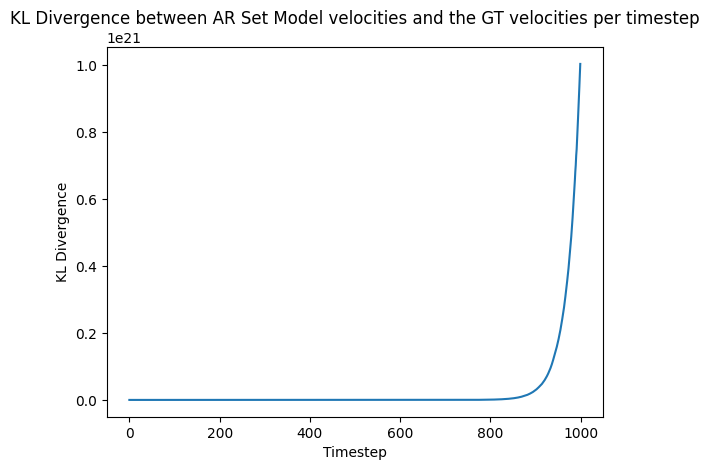

In [ ]:
validation_files = [pfn for pfn in os.listdir("../../data/boids/raw/") if (16 <= int(pfn.split("_")[-1][:-4]) < 25)]
validation_trajectories = [np.load("../../data/boids/raw/" + f) for f in validation_files]
validation_trajectories = torch.tensor(validation_trajectories, dtype=torch.float)

dists_GT = compute_distribution_per_timestep(validation_trajectories[:,:,:,2:], 1000)
dists_AR_set = compute_distribution_per_timestep(ar_set_model_rollout[:,:,:,2:], 1000)
plot_kl_divergence(dists_AR_set, dists_GT, title="KL Divergence between AR Set Model velocities and the GT velocities per timestep")



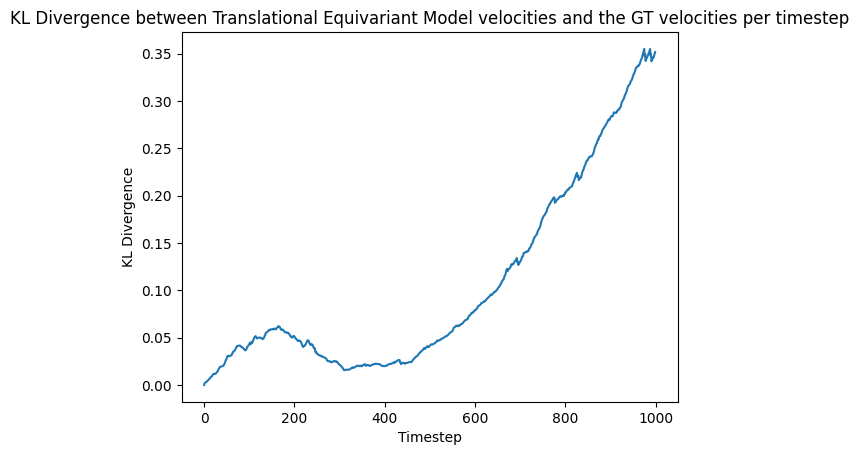

In [32]:
dists_equivariant = compute_distribution_per_timestep(translational_equivariant_model_rollout[:,:,:,2:], 1000)
plot_kl_divergence(dists_equivariant, dists_GT, title="KL Divergence between Translational Equivariant Model velocities and the GT velocities per timestep")

# References

[1] Minartz, K., Poels, Y., Koop, S., & Menkovski, V. (2023). Equivariant Neural Simulators for Stochastic Spatiotemporal Dynamics. https://openreview.net/forum?id=CCVsGbhFdj

[2] Reynolds, C. W. (1987) Flocks, Herds, and Schools: A Distributed Behavioral Model, in Computer Graphics, 21(4) (SIGGRAPH '87 Conference Proceedings) pages 25-34.

[3] Satorras, V. G., Hoogeboom, E., & Welling, M. (2021, July). E (n) equivariant graph neural networks. In International conference on machine learning (pp. 9323-9332). PMLR.